Reference - this code is just modification of https://github.com/dennybritz/reinforcement-learning, https://gist.github.com/kkweon/c8d1caabaf7b43317bc8825c226045d2

In [1]:
%run ../utils/commonImports.py
%run ../utils/tradingImports.py
%matplotlib inline

In [2]:
import gym
import itertools
import matplotlib
import sys
import tensorflow as tf
import collections

matplotlib.style.use('ggplot')

In [3]:
from collections import namedtuple
from matplotlib import pyplot as plt

def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode reward over time
    fig = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig)
    else:
        plt.show(fig)

    return fig

# Load Data

In [4]:
dataRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataFeatures\\poloniex\\5min'
fileName = 'USDT_BTC_5min_2016-01-01_2017-12-31.tsv'
file = '{dataRoot}\\{fileName}'.format(dataRoot=dataRoot, fileName=fileName)

usdtBtc = pd.read_csv(file, sep='\t').query("date >= '2017-01-01'")\
    .sort_values('date').reset_index().drop('index', axis=1)
usdtBtc = usdtBtc

trainRatio = 0.7
trainSize = int(usdtBtc.shape[0] * trainRatio)
usdtBtcTrain = usdtBtc.iloc[:trainSize]
usdtBtcTest = usdtBtc.iloc[trainSize:].reset_index().drop('index', axis=1)

usdtBtcManagerTrain = CurrencyDataManager(usdtBtcTrain['close'], usdtBtcTrain)
usdtBtcManagerTest = CurrencyDataManager(usdtBtcTest['close'], usdtBtcTest)
wallet = {'usdt': 1000}
contractPair = ContractPair.new('usdt', 'btc')

In [5]:
dataManager = deepcopy(usdtBtcManagerTrain)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)

# Dummy Estimators

Just to test learning performance

In [6]:
class DummyPolicyEstimator:
    def predict(self, state):
        return [0.7, 0.1, 0.2] 
    
    def update(self, state, target, action):
        pass

    
class DummyValueEstimator:
    def predict(self, state):
        return 0
    
    def update(self, state, target):
        pass

# Keras perceptron

# Reinforce

In [7]:
from modeling.rl.enviroment import ExchangeEnv

# cols = ['close', 'return', 'return_1', 'return_2', 'zscore_36_return', 'zscore_288_return']

env = ExchangeEnv(
    data=usdtBtcTrain.drop('date', axis=1),
    price_col='close',
    pair=contractPair,
    wallet=wallet,
    fee=0.0025,
    epoch_len=288,
    trade_amount=100
)

In [8]:
from modeling.rl.reinforce import reinforce
from modeling.rl.estimator import MLPPolicyEstimator, MLPValueEstimator

tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = MLPPolicyEstimator(env.observation_space.n, env.action_space.n, [env.observation_space.n])
value_estimator = MLPValueEstimator(env.observation_space.n, [env.observation_space.n])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    stats, episodes = reinforce(env, policy_estimator, value_estimator, 100, discount_factor=1.0)

Step 286 @ Episode 100/100 (-11.77747293720453)

C:\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [17]:
episode_stats = pd.DataFrame(episodes[-1])
for k in episode_stats['debug'].values[0].keys():
    episode_stats[k] = episode_stats['debug'].apply(lambda x: x[k])

In [18]:
episode_stats

,state,action,reward,next_state,done,debug,action_probs,current_value,open,err,initial_value
0,"[[-0.007468394219620422, -0.001765593353664329...",1,-0.0005,"[[0.001158309331985352, -0.007468394219620422,...",False,"{'action_probs': [0.23569977, 0.7643003, 0.0],...","[0.23569977, 0.7643003, 0.0]",999.7500,True,False,"1,000.0000"
1,"[[0.001158309331985352, -0.007468394219620422,...",2,-0.0008,"[[-0.0026168212860302464, 0.001158309331985352...",False,"{'action_probs': [0.2001318, 0.0, 0.7998682], ...","[0.2001318, 0.0, 0.7998682]",999.2390,False,False,"1,000.0000"
2,"[[-0.0026168212860302464, 0.001158309331985352...",1,-0.0012,"[[-0.0007496263147465099, -0.00261682128603024...",False,"{'action_probs': [0.23569977, 0.7643003, 0.0],...","[0.23569977, 0.7643003, 0.0]",998.9890,True,False,"1,000.0000"
3,"[[-0.0007496263147465099, -0.00261682128603024...",2,-0.0014,"[[-0.0015003750900225432, -0.00074962631474650...",False,"{'action_probs': [0.2001318, 0.0, 0.7998682], ...","[0.2001318, 0.0, 0.7998682]",998.5893,False,False,"1,000.0000"
4,"[[-0.0015003750900225432, -0.00074962631474650...",1,-0.0017,"[[0.009015777415443129, -0.0015003750900225432...",False,"{'action_probs': [0.23569977, 0.7643003, 0.0],...","[0.23569977, 0.7643003, 0.0]",998.3393,True,False,"1,000.0000"
5,"[[0.009015777415443129, -0.0015003750900225432...",2,-0.0019,"[[-0.0003723006255360594, 0.009015777415443129...",False,"{'action_probs': [0.2001318, 0.0, 0.7998682], ...","[0.2001318, 0.0, 0.7998682]",998.0522,False,False,"1,000.0000"
6,"[[-0.0003723006255360594, 0.009015777415443129...",1,-0.0022,"[[0.003683247623822439, -0.0003723006255360594...",False,"{'action_probs': [0.23569977, 0.7643003, 0.0],...","[0.23569977, 0.7643003, 0.0]",997.8022,True,False,"1,000.0000"
7,"[[0.003683247623822439, -0.0003723006255360594...",2,-0.0025,"[[-0.0001876026702655187, 0.003683247623822439...",False,"{'action_probs': [0.2001318, 0.0, 0.7998682], ...","[0.2001318, 0.0, 0.7998682]",997.5335,False,False,"1,000.0000"
8,"[[-0.0001876026702655187, 0.003683247623822439...",0,-0.0025,"[[0.005098719721371214, -0.0001876026702655187...",False,"{'action_probs': [0.23569977, 0.7643003, 0.0],...","[0.23569977, 0.7643003, 0.0]",997.5335,False,False,"1,000.0000"
9,"[[0.005098719721371214, -0.0001876026702655187...",0,-0.0025,"[[0.0011797224036291798, 0.005098719721371214,...",False,"{'action_probs': [0.23569977, 0.7643003, 0.0],...","[0.23569977, 0.7643003, 0.0]",997.5335,False,False,"1,000.0000"


In [11]:
episode_stats.iloc[1, [1, 5]]

action                                                    2
debug     {'action_probs': [0.2001318, 0.0, 0.7998682], ...
Name: 1, dtype: object

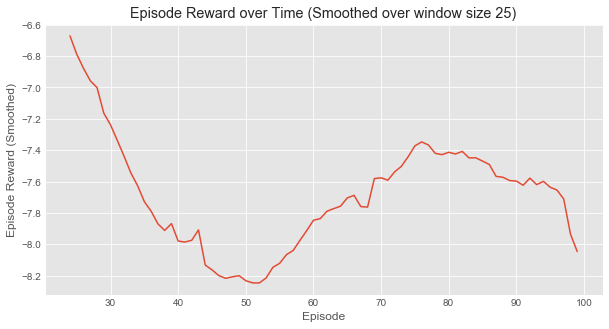

In [12]:
plot_episode_stats(stats, smoothing_window=25);